In [ ]:
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#1introduction
# TO USE:
# Uncomment three !pip install lines
# Run this cell ONLY
# Runtime -> Restart session
# Comment three !pip install lines
# Run all

!pip install pyLDAvis
!pip install --user -U nltk
!pip install "pandas==1.5.3"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 28.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicor

In [ ]:
#

import numpy as np
import json
import glob
import nltk
import pandas as pd #to work with csv files

# pd.__version__ = 2.0.0
print(pd.__version__)

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

1.5.3


In [ ]:
import os
#The function that loops through the data to check for optimal parameters to input into the LDA model would take over 16 hours to run,
#after a while the runtime disconnects, which makes the progress start from 0.
#so the purpose of this function is to make sure the runtime doesnt disconnect, while training for optimal params to input to lda model.

def check_and_reconnect_drive():
    try:
        # Check if Google Drive is still connected
        os.listdir('/content/drive')
    except:
        # If not, reconnect it
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)

# Then call this function every so often in your main script
check_and_reconnect_drive()

Mounted at /content/drive


In [ ]:
nltk.download('stopwords')

stopwords = stopwords.words("english") #get stopwords from nltk

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#stopwords.extend(['hi', 'anymore', 'years', 'ago', 'almost', 'somehow', 'remember', 'wants', 'either', 'enough', 'much', 'making', 'simple', 'things', 'add', 'actual', 'say', 'etc', 'anything', 'days', 'long', 'another', 'ever', 'yes', 'th', 'ice', 'mightymouse', 'should', 'obviously', 'even', 'lol', 'stuff', 'never', 'old', 'yr', 'bit', 'like', 'aka', 'nonsense', 'ok', 'absolutely', 'op', 'weird', 'ass', 'fully', 'get', 'would', 'definitely', 'especially', 'still', 'else', 'something', 'often', 'kind', 'let', 'lot', 'able', 'non', 'pg', 'nice', 'trad', 'keep', 'massive', 'quickly', 'be', 'common', 'tv', 'fuckin', 'im', 'could', 'also', 'silly', 'ie', 'seem', 'seems', 'fucked'])#Add custom stop words
stopwords.extend(['r/parenting', 'r/roblox', 'get'])#Add reddit paths

In [ ]:
def wordcounts(text1):
  fdist1 = FreqDist(text1)
  print(fdist1)
  fdist1.most_common(50)

In [ ]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

In [ ]:
def load_data(file):
  data = pd.read_csv(file)
  return data

In [ ]:
data = load_data('cumulative5.csv')
filtered_data = data.drop(columns=['subreddit','date','timestamp'], axis=1)
data = filtered_data.replace('\n', ' ', regex=True)
# data.head(5)

In [ ]:
# data[data.text.str.contains('I am a bot')]

In [ ]:
import re

data = data.loc[data.text.str.contains('I am a bot') == False, :]

# Remove punctuation
# data['text'] = data['text'].map(lambda x: re.sub("[,\.!?/@#$^&*-_=+()%]", "", x))
data['text'] = data['text'].replace(r'http\S+', '', regex=True)

#data['text'] = data['text'].replace(r'a'+ u'\u0301'+ 'U+20AC'+ 'U+2122', "'" , regex=True)

data['text'] = data['text'].map(lambda x: re.sub('[%$:,\.!?/-]', ' ', x))
data['text'] = data['text'].map(lambda x: re.sub('\(', ' ', x))
data['text'] = data['text'].map(lambda x: re.sub('\)', ' ', x))
data['text'] = data['text'].replace(r'&\S+', '', regex=True)
data['text'] = data['text'].replace('\"', '', regex=True)

# # Convert the titles to lowercase
data['text'] = data['text'].map(lambda x: x.lower())

pattern = r'[0-9]'
data['text'] = data['text'].map(lambda x: re.sub(pattern, ' ', x))
data['text'] = data['text'].map(lambda x: re.sub(' +', ' ', x))

data.shape

<ipython-input-12-5994bc70bab9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['text'].replace(r'http\S+', '', regex=True)


(12075, 1)

In [ ]:
data.columns

Index(['text'], dtype='object')

In [ ]:
data.head(5)

,text
0,live chat hi does anyone know if i can access ...
1,forgot pin i created my parental pin almost ye...
2,roblox rant this game…honestly either not enou...
3,you're not alone that's all i have to say
4,i even contacted support and they were useless


In [ ]:
data[data.text.str.contains('I am a bot')]

,text


In [ ]:
data['text'][51]

'definitely not for year olds i hope at the very least chat is not enabled there is a lot of random violence the best option is for them to only join a private server which are free and easy to set up with a couple of clicks for any game that includes only just the kids in the daycare '

In [ ]:
!pip install clean-text
from cleantext import clean

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 6.4 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=fc542be42d42a8ada16e36415aa58105eb13de0ff58f3058dc1afde90981f889
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji


In [ ]:
data = [clean(d, no_emoji=True) for d in data['text']]

In [ ]:
data = remove_stopwords(data)

In [ ]:
resultx = []
for d in data:
  resultx.append(' '.join(d))

#resultxtokens = resultx.split()


In [ ]:
resultx[:5]

['live chat hi anyone know access live chat history child account tried contacting roblox heard back',
 'forgot pin created parental pin almost years ago somehow remember son accidentally blocked brother tried email roblox reset pin son upset wants play brother reset without pin anyone else happen',
 'roblox rant gamehonestly either enough protection young kids much protection making game useless chat simple things add parental game controls parents approve friend requests outgoing incoming experience chats stored parent accessible actual inappropriate text controls anyone walk kid roblox say private parts etc friends experience chat history reported users missing anything specifically pissed find days long experience chat child another user extremely inappropriate zero way access anything regarding going honest open conversation child',
 'alone say',
 'even contacted support useless']

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
nltk.download('punkt')
words = [word_tokenize(i) for i in resultx]
words2= [num for elem in words for num in elem]
#words = nltk.tokenize.word_tokenize(resultx)

#wordcounts(words2)
fdist1 = FreqDist(words2)
#print(fdist1)
fdist1.most_common(50)


#>>> # flatten a list using a listcomp with two 'for'
#>>> vec = [[1,2,3], [4,5,6], [7,8,9]]
#>>> [num for elem in vec for num in elem]
#[1, 2, 3, 4, 5, 6, 7, 8, 9]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[('kids', 3958),
 ('like', 3569),
 ('roblox', 3167),
 ('games', 2714),
 ('time', 2643),
 ('game', 2527),
 ('play', 2502),
 ('would', 2230),
 ('kid', 2027),
 ('also', 1874),
 ('old', 1811),
 ('think', 1806),
 ('money', 1766),
 ('know', 1712),
 ('one', 1635),
 ('make', 1618),
 ('year', 1554),
 ('things', 1488),
 ('want', 1420),
 ('good', 1391),
 ('people', 1390),
 ('even', 1347),
 ('really', 1333),
 ('phone', 1333),
 ('something', 1299),
 ('child', 1255),
 ('much', 1246),
 ('let', 1211),
 ('way', 1203),
 ('daughter', 1187),
 ('son', 1185),
 ('friends', 1153),
 ('school', 1085),
 ('playing', 1080),
 ('parents', 1076),
 ('need', 1067),
 ('age', 1011),
 ('still', 1005),
 ('could', 1002),
 ('see', 964),
 ('use', 960),
 ('go', 946),
 ('day', 943),
 ('going', 935),
 ('thing', 933),
 ('back', 928),
 ('got', 920),
 ('lot', 902),
 ('say', 900),
 ('stuff', 827)]

In [ ]:
result = []
for d in data:
  result.append(' '.join(d))
# result

In [ ]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
      yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# data = filtered_data.review_text_processed.values.tolist()
data_words = list(sent_to_words(result))

# prints the first 30 words of the first tokenized review from the data_words list.
# print(data_words[:1][0][:30])

In [ ]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# # NO BIGRAMS
# !python -m spacy download en_core_web_sm
# import spacy

# # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# # Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [ ]:
# BIGRAMS DATA
!python -m spacy download en_core_web_sm
import spacy

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Form Trigrams
data_words_trigrams = make_trigrams(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


2024-01-27 19:34:07.010247: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-27 19:34:07.010338: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-27 19:34:07.012029: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-27 19:34:08.559594: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 27.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
print(type(data_lemmatized))

<class 'list'>


Remove Duplicate Words (TO REMOVE)

In [ ]:
# from collections import Counter
# def unique(d):
#   UniqW = Counter(d)
#   result = [*UniqW]
#   # corpus = ' '.join(UniqW.keys())
#   return result

In [ ]:
# single_data = []
# for d in data_lemmatized:
#   for word in d:
#     single_data.append(word)

In [ ]:
# unique_data = [unique(d) for d in data_lemmatized]
# # unique_data = unique(single_data)

In [ ]:
# print(type(unique_data))

<class 'list'>


In [ ]:
# unique_data

In [ ]:
from prompt_toolkit.completion import word_completer
id2word = corpora.Dictionary(data_lemmatized)
# id2word = corpora.Dictionary(bag_of_words)

corpus = []
for text in data_lemmatized:
  new = id2word.doc2bow(text)
  corpus.append(new)

print(corpus[0])

print(data_words[:1][0][:30])
# print(word_completer)

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1)]
['live', 'chat', 'hi', 'anyone', 'know', 'access', 'live', 'chat', 'history', 'child', 'account', 'tried', 'contacting', 'roblox', 'heard', 'back']


In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=5,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True,
                                       alpha=0.01,
                                       eta=0.61)

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds', R=30)
vis

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.242561  0.211461       1        1  88.750614
4      0.110097 -0.206192       2        1   6.837264
1     -0.154515 -0.047271       3        1   1.866747
2     -0.132844  0.055937       4        1   1.538094
0     -0.065299 -0.013934       5        1   1.007281, topic_info=             Term         Freq        Total Category  logprob  loglift
253           buy   850.000000   850.000000  Default  30.0000  30.0000
83          money   722.000000   722.000000  Default  29.0000  29.0000
1         account  1070.000000  1070.000000  Default  28.0000  28.0000
49           make  3504.000000  3504.000000  Default  27.0000  27.0000
1485          pet   520.000000   520.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
2850   censorship     4.514492    45.291793   Topic5  -6.4821   2.2921
11683        dope     4.507076    45.285987   Topic5  -6.4837   2.2906
794         adopt     7.201321  1100.529545   Topic5  -6.0151  -0.4314
4394        lobby     4.628646    88.043708   Topic5  -6.4571   1.6523
3126      pet_sim     4.155185   145.103769   Topic5  -6.5650   1.0448

[263 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
1          1  0.739923  account
1          2  0.258786  account
794        1  0.940456    adopt
794        2  0.051793    adopt
794        3  0.000909    adopt
...      ...       ...      ...
2612       1  0.225880      wth
2612       4  0.677641      wth
11658      1  0.211606      www
11658      5  0.634819      www
234        1  0.998971     year

[568 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 2, 3, 1])

In [ ]:
from pprint import pprint
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.010*"vote" + 0.007*"bot" + 0.005*"tos" + 0.004*"auto" + 0.004*"knife" + '
  '0.003*"beggar" + 0.003*"obbie" + 0.003*"scripting" + 0.003*"heavy" + '
  '0.003*"violate"'),
 (1,
  '0.008*"tho" + 0.006*"release" + 0.006*"classic" + 0.005*"piano" + '
  '0.004*"red" + 0.004*"nft" + 0.004*"makeup" + 0.004*"music" + 0.003*"epic" + '
  '0.003*"sonic"'),
 (2,
  '0.017*"donate" + 0.010*"obby_obby" + 0.008*"cry" + 0.008*"trading" + '
  '0.004*"wake" + 0.004*"electronic" + 0.004*"min" + 0.004*"bedtime" + '
  '0.003*"bed" + 0.003*"weapon"'),
 (3,
  '0.037*"game" + 0.015*"roblox" + 0.015*"play" + 0.013*"make" + 0.011*"kid" + '
  '0.010*"people" + 0.010*"go" + 0.009*"get" + 0.009*"thing" + 0.009*"time"'),
 (4,
  '0.036*"money" + 0.034*"buy" + 0.025*"pet" + 0.024*"scam" + 0.023*"robux" + '
  '0.015*"simulator" + 0.014*"account" + 0.013*"spend" + 0.012*"item" + '
  '0.012*"trade"')]


In [ ]:
from gensim.models import CoherenceModel

# Compute Coherence Score

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
# coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, corpus=corpus, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.5851379968163309


In [ ]:
# Get the topic distribution for each document
document_topics = lda_model.get_document_topics(corpus)

# Filter reviews that have topic 1 as their main topic
reviews_in_topic_1 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 1]

i = 0
# Print the reviews
for idx in reviews_in_topic_1:
    i += 1
    print(' '.join(data_words[idx]))

print(i)

In [ ]:

def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=k,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       alpha=a,
                                       eta=b,
                                       per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    return coherence_model_lda.get_coherence()

#data_words

In [ ]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}

 # Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
#A list of alpha values to be tested.
#It includes a range of values from 0.01 to 1 with a step size of 0.3, as well as two special values: 'symmetric' and 'asymmetric'.
alpha = list(np.arange(0.01, 1, 0.3))
 #assumes that all documents are equally likely to be a mixture of topics, resulting in a uniform distribution of topics across documents. So it maps rreviews to each topic evenly
 #It makes the model assume that every document should have roughly the same proportion of topics.
# alpha.append('symmetric')
# #allows for more variability in document-topic proportions.
# #It doesn't enforce a uniform distribution and allows documents to have varying degrees of focus on different topics.
alpha.append('asymmetric')

# # Beta parameter
# #A list of beta values to be tested. It follows a similar pattern to alpha, including a range and 'symmetric'.
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# # Validation sets:
# # We have the corpus sets, which contains 2 versions of the corpus, 15% and 20%
num_of_docs = len(corpus)

# #A list containing two versions of the 15% corpus, one with 20% of the documents and another with 15% of the documents.
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.20)),
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.15))]

corpus_title = ['20% Corpus', '15% Corpus']

#Stores the results of the LDA model with different hyperparameters.
model_results = {'Validation_Set': [],
                  'Topics': [],
                  'Alpha': [],
                  'Beta': [],
                  'Coherence': []
                 }

 # Can take a long time to run
if 1 == 1:
   #progress bar
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))

     # iterate through validation corpus sets
    for i in range(len(corpus_sets)):
         # iterate through number of topics
        for k in topics_range:
             # iterate through alpha values
            for a in alpha:
                 # iterare through beta values
                for b in beta:
                     #reconnect the runtime
                    check_and_reconnect_drive()
                     # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word,
                                                  k=k, a=a, b=b)

                     # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('/content/lda_tuning_results.csv', index=False)
     # pd.DataFrame(model_results).to_csv('/content/drive/My Drive/Classes/lda_tuning_results.csv', index=False)
    pbar.close()


  0%|          | 0/450 [00:22<?, ?it/s]

100%|██████████| 450/450 [1:02:20<00:00,  8.31s/it]


In [ ]:
# if 1==1:
# # pd.DataFrame(model_results).to_csv('./results/lda_tuning_results.csv', index=False)
#     pd.DataFrame(model_results).to_csv('/content/drive/My Drive/Classes/lda_tuning_results.csv', index=False)
#     pbar.close()

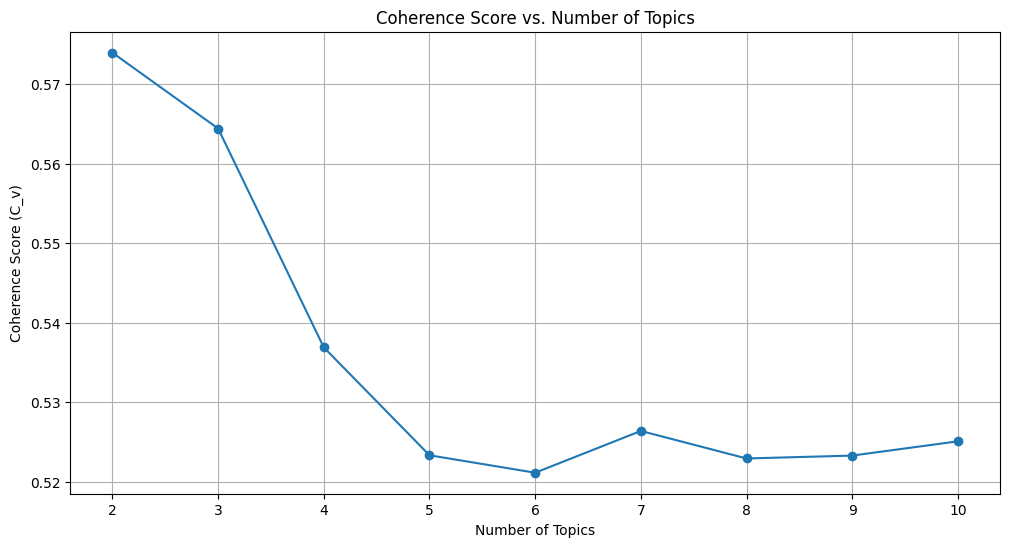

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the model results from the CSV file
model_results_df = pd.read_csv('/content/lda_tuning_results.csv')

# Filter the results for the 75% Corpus (you can change this if needed)
# filtered_results = model_results_df[model_results_df['Validation_Set'] == '20% Corpus']

# Group the results by the number of topics (Topics) and calculate the mean coherence score
coherence_by_topics = model_results_df.groupby('Topics')['Coherence'].mean()

# Plot the coherence score against the number of topics
plt.figure(figsize=(12, 6))
plt.plot(coherence_by_topics.index, coherence_by_topics.values, marker='o', linestyle='-')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score (C_v)')
plt.title('Coherence Score vs. Number of Topics')
plt.grid(True)
plt.show()

In [ ]:
data_topic_3 = model_results_df[model_results_df['Topics'] == 2]
max_coherence = np.array(data_topic_3['Coherence'])
print(max_coherence[4])
# print(np.argmax(max_coherence))

0.5715554779742691


##Visualizing the Data


In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds', R=30)
vis

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.242561  0.211461       1        1  88.750250
4      0.110097 -0.206192       2        1   6.841082
1     -0.154515 -0.047271       3        1   1.855328
2     -0.132844  0.055937       4        1   1.540828
0     -0.065299 -0.013934       5        1   1.012512, topic_info=             Term         Freq        Total Category  logprob  loglift
253           buy   851.000000   851.000000  Default  30.0000  30.0000
83          money   722.000000   722.000000  Default  29.0000  29.0000
1         account  1070.000000  1070.000000  Default  28.0000  28.0000
49           make  3505.000000  3505.000000  Default  27.0000  27.0000
1485          pet   520.000000   520.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
2850   censorship     4.537938    45.300035   Topic5  -6.4821   2.2919
11683        dope     4.530482    45.294168   Topic5  -6.4837   2.2904
794         adopt     7.238720  1100.591968   Topic5  -6.0151  -0.4314
4394        lobby     4.652684    88.053614   Topic5  -6.4571   1.6522
3126      pet_sim     4.176765   145.071873   Topic5  -6.5650   1.0450

[263 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
1          1  0.739819  account
1          2  0.258750  account
794        1  0.940403    adopt
794        2  0.051790    adopt
794        3  0.000909    adopt
...      ...       ...      ...
2612       1  0.225673      wth
2612       4  0.677018      wth
11658      1  0.211014      www
11658      5  0.633042      www
234        1  0.998975     year

[567 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 2, 3, 1])

In [ ]:
lda_model_tuned = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=2,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True,
                                       alpha=0.31,
                                       eta='symmetric')

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_tuned, corpus, id2word, mds='mmds', R=30)
vis

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.008974 -0.158379       1        1  81.832982
0      0.008974  0.158379       2        1  18.167018, topic_info=       Term         Freq        Total Category  logprob  loglift
41     game  7196.000000  7196.000000  Default  30.0000  30.0000
9    roblox  3073.000000  3073.000000  Default  29.0000  29.0000
49     make  3027.000000  3027.000000  Default  28.0000  28.0000
253     buy   845.000000   845.000000  Default  27.0000  27.0000
83    money   810.000000   810.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
277    also   236.112503  1405.074589   Topic2  -5.4174  -0.0780
131    good   239.060795  2214.088039   Topic2  -5.4050  -0.5203
27     want   232.938400  2310.955531   Topic2  -5.4309  -0.5891
51     much   221.568042  1194.734325   Topic2  -5.4810   0.0206
71      way   216.681014  1410.846567   Topic2  -5.5033  -0.1680

[142 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1         1  0.001475  account
1         2  0.998492  account
30        1  0.351036      add
30        2  0.647467      add
794       1  0.017693    adopt
...     ...       ...      ...
71        1  0.846300      way
71        2  0.153808      way
394       1  0.869039     well
394       2  0.130620     well
234       1  0.999933     year

[192 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [ ]:
# Get the topic distribution for each document
document_topics = lda_model.get_document_topics(corpus)
print(document_topics)


In [ ]:
# Filter reviews that have topic 1 as their main topic
reviews_in_topic_1 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 1]

# Get the number of reviews in topic 1
num_reviews_in_topic_1 = len(reviews_in_topic_1)

print(f'There are {num_reviews_in_topic_1} reviews in topic 1.')


There are 120 reviews in topic 1.


In [ ]:
#import pandas as pd
#reviews_in_topic_1 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 1]

#mixture = [dict(lda_model[x]) for x in corpus]
pd.DataFrame(reviews_in_topic_1).to_csv("topic_mixture.csv")

In [ ]:
print(max(document_topics))

[(4, 0.99987066)]


In [ ]:
# Filter reviews that have topic 5 as their main topic
reviews_in_topic_5 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 5]

# Get the number of reviews in topic 5
num_reviews_in_topic_5 = len(reviews_in_topic_5)

print(f'There are {num_reviews_in_topic_5} reviews in topic 5.')

There are 0 reviews in topic 5.


In [ ]:
datax= load_data('cumulative5.csv')
filtered_data = datax.drop(columns=['subreddit','date','timestamp'], axis=1)
datax= filtered_data.replace('\n', ' ', regex=True)
import re

datax= datax.loc[datax.text.str.contains('I am a bot') == False, :]

# Remove punctuation
# data['text'] = data['text'].map(lambda x: re.sub("[,\.!?/@#$^&*-_=+()%]", "", x))
datax['text'] = datax['text'].replace(r'http\S+', '', regex=True)

#data['text'] = data['text'].replace(r'a'+ u'\u0301'+ 'U+20AC'+ 'U+2122', "'" , regex=True)

datax['text'] = datax['text'].map(lambda x: re.sub('[%$:,\.!?/-]', ' ', x))
datax['text'] = datax['text'].map(lambda x: re.sub('\(', ' ', x))
datax['text'] = datax['text'].map(lambda x: re.sub('\)', ' ', x))
datax['text'] = datax['text'].replace(r'&\S+', '', regex=True)
datax['text'] = datax['text'].replace('\"', '', regex=True)

# # Convert the titles to lowercase
datax['text'] = datax['text'].map(lambda x: x.lower())

pattern = r'[0-9]'
datax['text'] = datax['text'].map(lambda x: re.sub(pattern, ' ', x))
datax['text'] = datax['text'].map(lambda x: re.sub(' +', ' ', x))

datax.shape

(12075, 1)

In [ ]:
datax.head(5)

,text
0,live chat hi does anyone know if i can access ...
1,forgot pin i created my parental pin almost ye...
2,roblox rant this game…honestly either not enou...
3,you're not alone that's all i have to say
4,i even contacted support and they were useless


In [ ]:
datax['text'][3]
type(datax['text'][3])

resultx2 = []
for d in datax['text']:
  resultx2.append(d)

#resultx2.head[5]

In [ ]:
# Get the comments without weird spaces


i = 0
# Print the reviews
#filex=[""]
id=[" "]
textx=[" "]
comment=""
for i in datax['text']:
    #i += 1
    #print(idx)
    #print(' '.join(data_words[ix]))
    id.append(i)
    textx.append(i)
    # create a dictionary with the three lists
dict = {'ID': id,'Text':textx}

# create a Pandas DataFrame from the dictionary
df = pd.DataFrame(dict)

# write the DataFrame to a CSV file
df.to_csv('Data.csv')

#pd.DataFrame(filex).to_csv("topic_mixture1.csv")
#print(i)


In [ ]:
# Get the topic distribution for each document
document_topics = lda_model.get_document_topics(corpus)

# Filter reviews that have topic 1 as their main topic
reviews_in_topic_1_tuned = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 1]

i = 0
# Print the reviews
filex=[""]
id=[" "]
textx=[" "]
comment=""
for idx in reviews_in_topic_1:
    i += 1
    #print(idx)
    #print(' '.join(data_words[idx]))
    filex.append(data_words[idx])
    id.append(idx)
    textx.append(resultx2[idx])
    # create a dictionary with the three lists
dict = {'top words': filex, 'ID': id,'Text':textx}

# create a Pandas DataFrame from the dictionary
df = pd.DataFrame(dict)

# write the DataFrame to a CSV file
df.to_csv('EmployeeData.csv')

#pd.DataFrame(filex).to_csv("topic_mixture1.csv")
#print(i)


In [ ]:
# Get the topic distribution for each document
document_topics_tuned = lda_model_tuned.get_document_topics(corpus)

# Filter reviews that have topic 1 as their main topic
reviews_in_topic_1_tuned = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 1]

i = 0
# Print the reviews
for idx in reviews_in_topic_1_tuned:
    i += 1
    print(' '.join(data_words[idx]))

print(i)

In [ ]:
# Filter reviews that have topic 1 as their main topic
reviews_in_topic_2_tuned = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 2]

i = 0
# Print the reviews
filex=[""]
id=[" "]
textx=[" "]
comment=""
for idx in reviews_in_topic_2_tuned:
    i += 1
    #print(idx)
    #print(' '.join(data_words[idx]))
    filex.append(data_words[idx])
    id.append(idx)
    textx.append(resultx2[idx])
    # create a dictionary with the three lists
dict = {'top words': filex, 'ID': id,'Text':textx}

# create a Pandas DataFrame from the dictionary
df = pd.DataFrame(dict)

# write the DataFrame to a CSV file
df.to_csv('EmployeeData2.csv')

#pd.DataFrame(filex).to_csv("topic_mixture1.csv")
#print(i)
